In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from keras.preprocessing.text import Tokenizer
from keras import preprocessing
from keras.models import Sequential
from keras.layers import Flatten, Dense
from keras.layers import Embedding,SimpleRNN
import re
import string
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
file = "//content//drive//MyDrive//PhishingEmail.csv"

In [ ]:
import chardet
with open(file, 'rb') as rawdata:
    result = chardet.detect(rawdata.read(100000))
result


{'confidence': 0.7270322499829184, 'encoding': 'Windows-1252', 'language': ''}

In [ ]:
data=pd.read_csv(file,encoding='Windows-1252')

In [ ]:
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [ ]:
data["email"] = data.v2
data["spam"] = data.v1

In [ ]:
from sklearn.model_selection import train_test_split
emails_train, emails_test, target_train, target_test = train_test_split(data.email,data.spam,test_size = 0.2)

In [ ]:
data.info

<bound method DataFrame.info of         v1  ...  spam
0      ham  ...   ham
1      ham  ...   ham
2     spam  ...  spam
3      ham  ...   ham
4      ham  ...   ham
...    ...  ...   ...
5567  spam  ...  spam
5568   ham  ...   ham
5569   ham  ...   ham
5570   ham  ...   ham
5571   ham  ...   ham

[5572 rows x 7 columns]>

In [ ]:
emails_train.shape

(4457,)

In [ ]:
def remove_hyperlink(word):
    return  re.sub(r"http\S+", "", word)

def to_lower(word):
    result = word.lower()
    return result

def remove_number(word):
    result = re.sub(r'\d+', '', word)
    return result

def remove_punctuation(word):
    result = word.translate(str.maketrans(dict.fromkeys(string.punctuation)))
    return result

def remove_whitespace(word):
    result = word.strip()
    return result

def replace_newline(word):
    return word.replace('\n','')



def clean_up_pipeline(sentence):
    cleaning_utils = [remove_hyperlink,
                      replace_newline,
                      to_lower,
                      remove_number,
                      remove_punctuation,remove_whitespace]
    for o in cleaning_utils:
        sentence = o(sentence)
    return sentence

x_train = [clean_up_pipeline(o) for o in emails_train]
x_test = [clean_up_pipeline(o) for o in emails_test]

x_train[0]

'remind me how to get there and i shall do so'

In [ ]:
data.describe()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4,email,spam
count,5572,5572,50,12,6,5572,5572
unique,2,5169,43,10,5,5169,2
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""","MK17 92H. 450Ppw 16""","GNT:-)""","Sorry, I'll call later",ham
freq,4825,30,3,2,2,30,4825


In [ ]:
data.columns

Index(['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'email', 'spam'], dtype='object')

In [ ]:
data.shape

(5572, 7)

In [ ]:
c=0
for i in data['v1'].values:
  if i == 'ham':
    c += 1
print(str(c) +" " + "are legit in dataset")

4825 are illegitimate in dataset


In [ ]:
c1=0
for i in data['v1'].values:
  if i == 'spam':
    c1 += 1
print(str(c1) +" " + "are illegitimate in dataset")

747 are illegitimate in dataset


In [ ]:
v = []
for i in data['v2'].values:
  if i not in v:
    v.append(i)
v = set(v)
print("No of unique words in the dataset"+" " +str(len(v)))

No of unique words in the dataset 5169


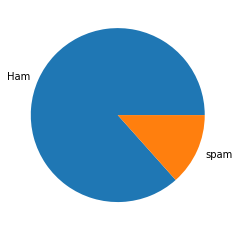

In [ ]:
import matplotlib.pyplot as plt
plt.pie(x=[4825,747],labels = ['Ham',"spam"])
plt.show()

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_y = le.fit_transform(target_train.values)
test_y = le.transform(target_test.values)

In [ ]:
train_y

array([0, 0, 0, ..., 1, 0, 0])

In [ ]:

## some config values 
embed_size = 100 # how big is each word vector
max_feature = 50000 # how many unique words to use (i.e num rows in embedding vector)
max_len = 2000 # max number of words in a question to use

In [ ]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=max_feature)

tokenizer.fit_on_texts(x_train)

x_train_features = np.array(tokenizer.texts_to_sequences(x_train))
x_test_features = np.array(tokenizer.texts_to_sequences(x_test))

x_train_features[0]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys


[1538, 10, 54, 2, 30, 69, 7, 1, 492, 29, 22]

In [ ]:
from keras.preprocessing.sequence import pad_sequences
x_train_features = pad_sequences(x_train_features,maxlen=max_len)
x_test_features = pad_sequences(x_test_features,maxlen=max_len)
x_train_features[0]

array([  0,   0,   0, ..., 492,  29,  22], dtype=int32)

In [ ]:
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional
from keras.models import Model

In [ ]:
import tensorflow as tf
embedding_vecor_length = 32

model = tf.keras.Sequential()
model.add(Embedding(max_feature, embedding_vecor_length, input_length=max_len))
model.add(Bidirectional(tf.keras.layers.LSTM(64)))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 2000, 32)          1600000   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               49664     
_________________________________________________________________
dense (Dense)                (None, 16)                2064      
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 1,651,745
Trainable params: 1,651,745
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
history = model.fit(x_train_features, train_y, batch_size=512, epochs=20, validation_data=(x_test_features, test_y))

Epoch 1/20
9/9 [==============================] - 241s 25s/step - loss: 0.6563 - accuracy: 0.8709 - val_loss: 0.5087 - val_accuracy: 0.8637
Epoch 2/20
9/9 [==============================] - 197s 22s/step - loss: 0.4448 - accuracy: 0.8709 - val_loss: 0.3744 - val_accuracy: 0.8637
Epoch 3/20
9/9 [==============================] - 166s 18s/step - loss: 0.3625 - accuracy: 0.8702 - val_loss: 0.3560 - val_accuracy: 0.8637
Epoch 4/20
9/9 [==============================] - 172s 19s/step - loss: 0.3290 - accuracy: 0.8709 - val_loss: 0.2809 - val_accuracy: 0.8637
Epoch 5/20
9/9 [==============================] - 161s 18s/step - loss: 0.2427 - accuracy: 0.8665 - val_loss: 0.2113 - val_accuracy: 0.8637
Epoch 6/20
9/9 [==============================] - 160s 18s/step - loss: 0.1731 - accuracy: 0.8673 - val_loss: 0.1744 - val_accuracy: 0.8637
Epoch 7/20
9/9 [==============================] - 159s 18s/step - loss: 0.1424 - accuracy: 0.8623 - val_loss: 0.1565 - val_accuracy: 0.8637
Epoch 8/20
9/9 [====

In [ ]:
model.save("mymodel")

INFO:tensorflow:Assets written to: mymodel/assets


INFO:tensorflow:Assets written to: mymodel/assets


In [ ]:
import joblib
filename = 'finalized_model.sav'
joblib.dump(model, filename)

TypeError: ignored

In [ ]:
model.save("final.h5")

In [ ]:
prediction = model.predict(x_test_features)

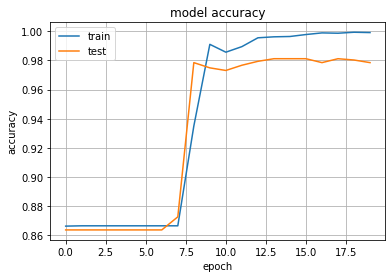

In [ ]:
from  matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()

In [ ]:

from sklearn.metrics import confusion_matrix,f1_score, precision_score,recall_score

In [ ]:
cf_matrix =confusion_matrix(test_y,y_predict)

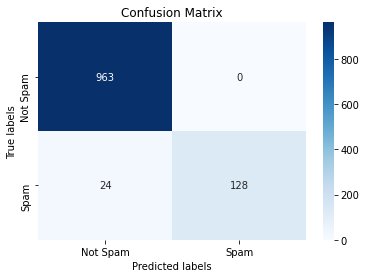

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(cf_matrix, annot=True, ax = ax,cmap='Blues',fmt=''); 

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Not Spam', 'Spam']); ax.yaxis.set_ticklabels(['Not Spam', 'Spam']);

In [ ]:

y_predict  = [1 if o>0.5 else 0 for o in model.predict(x_test_features)]

In [ ]:
tn, fp, fn, tp = confusion_matrix(test_y,y_predict).ravel()

In [ ]:

print("Precision: {:.2f}%".format(100 * precision_score(test_y, y_predict)))
print("Recall: {:.2f}%".format(100 * recall_score(test_y, y_predict)))
print("F1 Score: {:.2f}%".format(100 * f1_score(test_y,y_predict)))

Precision: 100.00%
Recall: 84.21%
F1 Score: 91.43%


In [ ]:

f1_score(test_y,y_predict)

0.9142857142857143